C:\Users\Almazt\AppData\Local\Temp\ipykernel_17900\1810135624.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


              MSISDN     duration       Totaldl     Totalul  Session_Frequency
0       3.360100e+10  116720140.0  8.426375e+08  36053108.0                  1
1       3.360100e+10  181230963.0  1.207552e+08  36104459.0                  1
2       3.360100e+10  134969374.0  5.566597e+08  39306820.0                  1
3       3.360101e+10   49878024.0  4.019932e+08  20327526.0                  1
4       3.360101e+10   37104453.0  1.363130e+09  94280527.0                  2
...              ...          ...           ...         ...                ...
106851  3.379000e+10    8810688.0  6.879252e+08  26716429.0                  1
106852  3.379000e+10  140988659.0  4.445751e+08  35732243.0                  1
106853  3.197021e+12  877385325.0  1.948281e+08  37295915.0                  1
106854  3.370000e+14  253030201.0  5.396350e+08  56652839.0                  1
106855  8.823971e+14  869844200.0  7.869760e+07  60456049.0                  1

[106856 rows x 5 columns]
Top 10 Customers by Durat

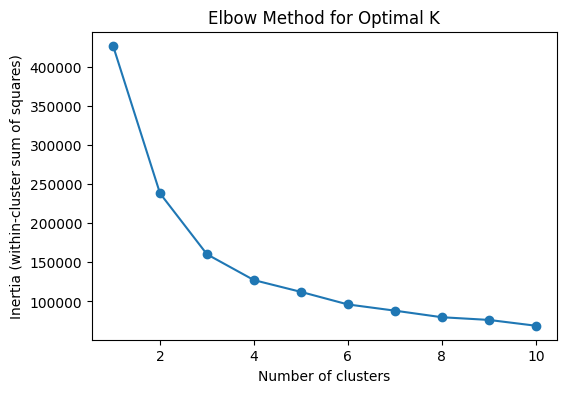

Cluster Centers: [[ 3.73245087  2.62599188  3.08896192  3.51914541]
 [-0.47519856 -0.23017157 -0.384847   -0.44796828]
 [ 0.95434575  0.33926055  0.76294256  0.89957249]]
         MSISDN  Cluster
0  3.360100e+10        1
1  3.360100e+10        1
2  3.360100e+10        1
3  3.360101e+10        1
4  3.360101e+10        2


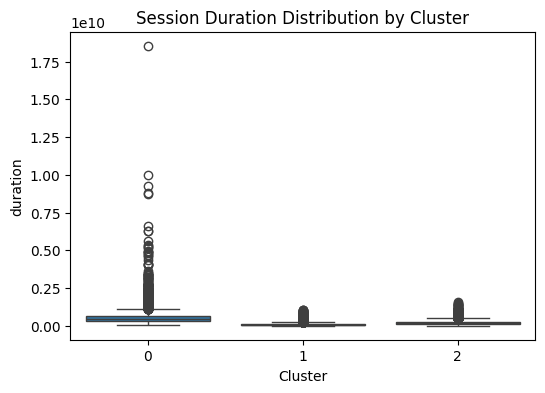

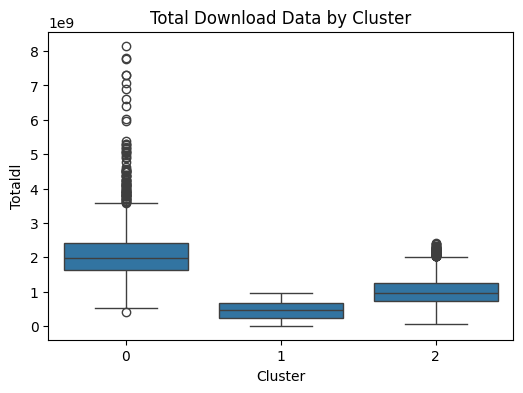

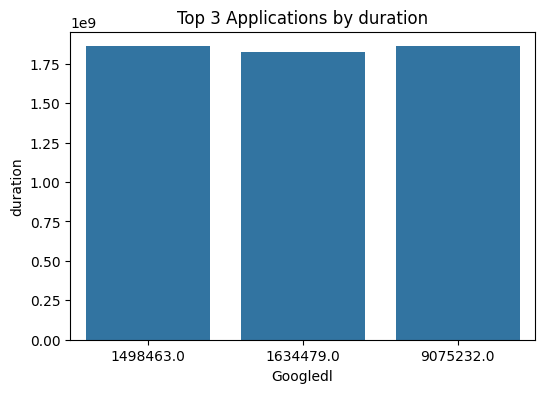

OSError: Cannot save file into a non-existent directory: '..\Task 2  User Engagement Analysis\data'

In [1]:
# Step 1: Engagement Metrics Aggregation
# 1.1 Calculate Session Frequency, Duration, and Traffic per User
# Assuming you have data in a DataFrame df, where columns include MSISDN (user), Session_Duration, Total_DL, Total_UL, here’s how you can aggregate the metrics for each user.

# Utilize the matplotlib and seaborn libraries to create plots.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Connect to psycopg2 database (or create it if it doesn't exist)
from sqlalchemy import create_engine

connection = psycopg2.connect("dbname=Teleco user=postgres password=Leul@123")

# Create a cursor object to interact with the database
cursor = connection.cursor()

# Query the data
query = "SELECT * FROM xdr_data"

# Load data into a pandas DataFrame
df = pd.read_sql_query(query, connection)

# Aggregating metrics per user (MSISDN)
user_engagement = df.groupby('MSISDN').agg({
    'duration': 'sum',  # Total session time per user
    'Totaldl': 'sum',  # Total download per user
    'Totalul': 'sum',  # Total upload per user
}).reset_index()

# Calculate the session frequency (session count per user)
session_frequency = df.groupby('MSISDN').size().reset_index(name='Session_Frequency')

# Merge frequency with aggregated metrics
user_engagement = user_engagement.merge(session_frequency, on='MSISDN')

# Preview the aggregated data
print(user_engagement)
# 1.2 Determine Top 10 Customers for Each Metric
# Now that you have the metrics, let's identify the top 10 customers for each metric.

# Top 10 customers by session duration
top_10_duration = user_engagement.sort_values(by='duration', ascending=False).head(10)

# Top 10 customers by download data
top_10_download = user_engagement.sort_values(by='Totaldl', ascending=False).head(10)

# Top 10 customers by upload data
top_10_upload = user_engagement.sort_values(by='Totalul', ascending=False).head(10)

print("Top 10 Customers by Duration:", top_10_duration)
print("Top 10 Customers by Download:", top_10_download)
print("Top 10 Customers by Upload:", top_10_upload)

# Step 2: Clustering & Optimization
# 2.1 Normalize Engagement Metrics
# Before performing K-means clustering, the metrics should be normalized. You can use StandardScaler from sklearn.preprocessing for normalization.

from sklearn.preprocessing import StandardScaler

# Select the columns to normalize (i.e., Session_Frequency, Duration, Download, Upload)
metrics = user_engagement[['Session_Frequency', 'duration', 'Totaldl', 'Totalul']]

# Initialize scaler
scaler = StandardScaler()

# Normalize the metrics
normalized_metrics = scaler.fit_transform(metrics)

# Convert back to DataFrame
normalized_user_engagement = pd.DataFrame(normalized_metrics, columns=metrics.columns)

# Preview normalized data
print(normalized_user_engagement.head())

# 2.2 Perform K-means Clustering & Elbow Method for Optimal k
# Now, use the KMeans algorithm to perform clustering and find the optimal number of clusters using the elbow method.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use the normalized data for clustering
inertia = []
for k in range(1, 11):  # Testing k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_user_engagement)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.show()
# 2.3 Run K-means for Optimal k
# Based on the elbow plot, choose the optimal k. For example, if the elbow is at k=3 (most common), you can apply K-means as follows:

# Run KMeans with optimal k
kmeans = KMeans(n_clusters=3, random_state=0)
user_engagement['Cluster'] = kmeans.fit_predict(normalized_user_engagement)

# Print cluster centers
print("Cluster Centers:", kmeans.cluster_centers_)

# Print clustered data
print(user_engagement[['MSISDN', 'Cluster']].head())

# Step 3: Insights & Interpretation
# 3.1 Visualize Cluster Statistics
# You can use matplotlib or seaborn to visualize the distribution of each cluster in terms of the engagement metrics.

import seaborn as sns

# Visualize distribution of session duration by cluster
plt.figure(figsize=(6, 4))
sns.boxplot(x='Cluster', y='duration', data=user_engagement)
plt.title('Session Duration Distribution by Cluster')
plt.show()

# Visualize total download by cluster
plt.figure(figsize=(6, 4))
sns.boxplot(x='Cluster', y='Totaldl', data=user_engagement)
plt.title('Total Download Data by Cluster')
plt.show()

# 3.2 Bar Plots for Top Applications
# Let’s say you have an Application column to identify the user’s engagement with specific apps. You can summarize and plot the data.

# Aggregate data by application
app_usage = df.groupby(['Googledl','Googleul','Emaildl','Emailul']).agg({
    'duration': 'sum',
    'Totaldl': 'sum',
    'Totalul': 'sum'
}).reset_index()

# Plot Top 3 Applications by Session Duration
top_apps = app_usage.sort_values(by='duration', ascending=False).head(3)

plt.figure(figsize=(6, 4))
sns.barplot(x='Googledl', y='duration', data=top_apps)
plt.title('Top 3 Applications by duration')
plt.show()

import os
import pickle

# Create directory if it doesn't exist
output_dir = "../Task 2  User Engagement Analysis/data"
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(output_dir, "user_engagment.csv"), index=False)